# Timing and Measuring Throughput

In [29]:
import pyopencl as cl
import pyopencl.array
import pyopencl.clrandom
import numpy as np
import numpy.linalg as la
from time import time
import matplotlib.pyplot as plt

In [20]:
ctx = cl.create_some_context(interactive=True)
queue = cl.CommandQueue(ctx)

Choose platform:
[0] <pyopencl.Platform 'Portable Computing Language' at 0x7f53bc5865c0>
[1] <pyopencl.Platform 'Intel(R) OpenCL' at 0x27c05d8>


Choice [0]: 1


Set the environment variable PYOPENCL_CTX='1' to avoid being asked again.


In [24]:
n = 10**8 * 2
x = cl.clrandom.rand(queue, n, np.float32)

In [36]:
intensities = []
timings = []
ops = []

for nops in range(4, 48, 4):
    print(nops)

    lines = ["op_t xi = x[i];", "op_t v = xi;"]
    for n in range(nops):
        lines.append("v = xi*(xi+v);")
        
    operations = 2*nops
    ops.append(operations)
    intensity = operations / x.dtype.itemsize
    intensities.append(intensity)
    
    src = """
    typedef float op_t;
    __kernel void perftest(__global op_t *x, __global op_t *output)
    {
      int i = get_global_id(0);
      %s
      output[i] = v;
    }
    """ % ("\n".join(lines))
    #print(src)
    prg = cl.Program(ctx, src).build()
    knl = prg.perftest
    
    output = cl.array.empty_like(x)
    for i in range(3):
        knl(queue, x.shape, (512,), x.data, output.data)
        
    nruns = 10
    queue.finish()
    start_t = time()
    for i in range(nruns):
        knl(queue, x.shape, (512,), x.data, output.data)
    queue.finish()
    timings.append((time()-start_t)/nruns)

4
8
12
16
20
24
28
32
36
40
44


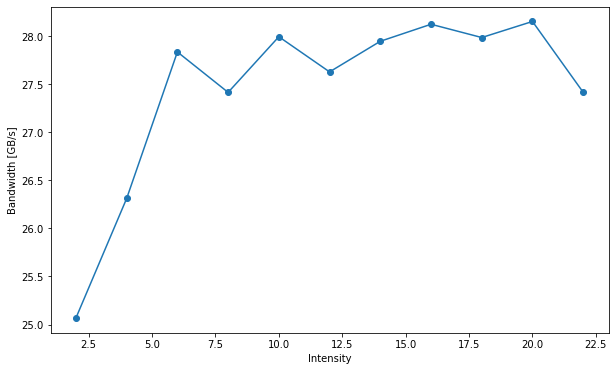

In [34]:
plt.figure(figsize=(10, 6))
plt.xlabel("Intensity")
plt.ylabel("Bandwidth [GB/s]")

timings = np.array(timings)
gflops = np.array(operations(2*x.size/1e9)/timings

plt.plot(intensities, bandwidth, "o-")